In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F  # useful stateless functions

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img)
    plt.gca().axis('off')

In [2]:
NUM_TRAIN = 100

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor()
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 150)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

images = {}

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment. Note that if your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cpu


In [4]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()

Before flattening:  tensor([[[[  0.,   1.],
          [  2.,   3.],
          [  4.,   5.]]],


        [[[  6.,   7.],
          [  8.,   9.],
          [ 10.,  11.]]]])
After flattening:  tensor([[  0.,   1.,   2.,   3.,   4.,   5.],
        [  6.,   7.,   8.,   9.,  10.,  11.]])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [5]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            reconstruction = model(x)
            loss_function = nn.MSELoss()
            loss = loss_function(reconstruction, x)
            #y = y.to(device=device, dtype=torch.long)
            #scores = model(x)
            #_, preds = scores.max(1)
            #num_correct += (preds == y).sum()
            #num_samples += preds.size(0)
        #acc = float(num_correct) / num_samples
        #print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [34]:
def train_part34(model, optimizer, epochs=10):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loss_history = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float)

            reconstruction = model(x)
            loss_function = nn.MSELoss()
            loss = loss_function(reconstruction, x)
            #i = 0
            #for image in x:
                #images[image] = reconstruction[i]
                #imshow_noax(image, normalize=False)
                #imshow_noax(reconstruction[i], normalize=False)
                #plt.imshow(image.detach().numpy().transpose(2,1,0))
                #plt.imshow(reconstruction[i].detach().numpy().transpose(2,1,0))
                #i += 1

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            loss_history.append(loss.item())

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                #check_accuracy_part34(loader_val, model)
                print()
    i = 0
    for image in x:
        images[image] = reconstruction[i]
        i += 1

# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.

Again, you don't need to tune any hyperparameters here, but you shoud achieve above 40% accuracy after one epoch of training.

In [31]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

hidden_layer_size = 4000
learning_rate = 1e-2

model = nn.Sequential(
    Flatten(),
    nn.Linear(3 * 32 * 32, hidden_layer_size),
    nn.ReLU(),
    nn.Linear(hidden_layer_size, 10),
)

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)

train_part34(model, optimizer)

RuntimeError: input and target shapes do not match: input [64 x 10], target [64 x 3 x 32 x 32] at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THNN/generic/MSECriterion.c:13

### Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, you don't need to tune any hyperparameters but you should see accuracy above 55% after one epoch of training.

In [32]:
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

model = None
optimizer = None

################################################################################                                                          #
################################################################################
class ThreeLayerConvNet_Sequential(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channel,channel_1, 5,padding=2,bias=True)
        self.relu_1 = nn.ReLU()
        self.conv_2 = nn.Conv2d(channel_1,channel_2, 3,padding=1,bias=True) 
        self.relu_2 = nn.ReLU()
        
        self.affine_out = nn.Linear(channel_2*32*32,num_classes,bias=True) #TODO CHANGE THIS 
        
    def forward(self, x):
        scores = None
        model = torch.nn.Sequential( #I didn't realize that we were introduced to nn.Sequential later...
            self.conv_1,        
            self.relu_1,
            self.conv_2,
            self.relu_2,
            Flatten(),
            self.affine_out,
        ).to(device)
        scores = model(x)
        return scores

class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x
    
model = ThreeLayerConvNet_Sequential(3,channel_1, channel_2, 10)
# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)


################################################################################
#                                 END OF YOUR CODE                             
################################################################################

train_part34(model, optimizer, num_epochs=100, print_every=1)

TypeError: train_part34() got an unexpected keyword argument 'num_epochs'

# Part V. CIFAR-10 open-ended challenge

In this section, you can experiment with whatever ConvNet architecture you'd like on CIFAR-10. 

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You can use either `nn.Module` or `nn.Sequential` API. 

Describe what you did at the end of this notebook.

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

### Have fun and happy training! 

In [35]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and  hyperparameter   #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
class TestConvNet(nn.Module):
    def __init__(self,channels,size):
        super().__init__()

        self.conv_1_compress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_compress = nn.ReLU()
        
        self.conv_2_compress = nn.Conv2d(size, size, kernel_size=3,stride=2,padding=1,bias=True)
        self.batchnorm_2_compress = nn.BatchNorm2d(size)
        self.relu_2_compress = nn.ReLU()
        
        self.conv_3 = nn.Conv2d(size, channels, kernel_size=3,stride=1,padding=1,bias=True)
        
        self.upscaling = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_1_decompress = nn.Conv2d(channels, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.relu_1_decompress = nn.ReLU()
        
        self.conv_2_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_2_decompress = nn.BatchNorm2d(size)
        self.relu_2_decompress = nn.ReLU()
        
        self.conv_3_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_3_decompress = nn.BatchNorm2d(size)
        self.relu_3_decompress = nn.ReLU()
        
        self.conv_4_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_4_decompress = nn.BatchNorm2d(size)
        self.relu_4_decompress = nn.ReLU()
        
        self.conv_5_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_5_decompress = nn.BatchNorm2d(size)
        self.relu_5_decompress = nn.ReLU()
        
        self.conv_6_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_6_decompress = nn.BatchNorm2d(size)
        self.relu_6_decompress = nn.ReLU()
        
        self.conv_7_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_7_decompress = nn.BatchNorm2d(size)
        self.relu_7_decompress = nn.ReLU()
        
        self.conv_8_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_8_decompress = nn.BatchNorm2d(size)
        self.relu_8_decompress = nn.ReLU()
        
        self.conv_9_decompress = nn.Conv2d(size, size, kernel_size=3,stride=1,padding=1,bias=True)
        self.batchnorm_9_decompress = nn.BatchNorm2d(size)
        self.relu_9_decompress = nn.ReLU()
        
        self.conv_10_decompress = nn.Conv2d(size, 3, kernel_size=3,stride=1,padding=1,bias=True)
        

    def forward(self, x):
        scores = None
        model = torch.nn.Sequential( #I didn't realize that we were introduced to nn.Sequential later...
            
            self.conv_1_compress,
            self.relu_1_compress,
        
            self.conv_2_compress,
            self.batchnorm_2_compress,
            self.relu_2_compress,
            
            self.conv_3,
        
            self.upscaling,
            
            self.conv_1_decompress,
            self.relu_1_decompress,
        
            self.conv_2_decompress,
            self.batchnorm_2_decompress,
            self.relu_2_decompress,
            
            self.conv_3_decompress,
            self.batchnorm_3_decompress,
            self.relu_3_decompress,
            
            self.conv_4_decompress,
            self.batchnorm_4_decompress,
            self.relu_4_decompress,
            
            self.conv_5_decompress,
            self.batchnorm_5_decompress,
            self.relu_5_decompress,
            
            self.conv_6_decompress,
            self.batchnorm_6_decompress,
            self.relu_6_decompress,
            
            self.conv_7_decompress,
            self.batchnorm_7_decompress,
            self.relu_7_decompress,
            
            self.conv_8_decompress,
            self.batchnorm_8_decompress,
            self.relu_8_decompress,
            
            self.conv_9_decompress,
            self.batchnorm_9_decompress,
            self.relu_9_decompress,
        
            self.conv_10_decompress

            
        ).to(device)
        scores = model(x)
        return scores
    


class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

channels = 3
size = 32

model = TestConvNet(channels, size)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
                     #momentum=0.9, nesterov=True)#optim.SGD(model.parameters(), lr=5e-3)

################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
train_part34(model, optimizer, epochs=10)

Iteration 0, loss = 0.2196

Iteration 0, loss = 0.1948

Iteration 0, loss = 0.0610

Iteration 0, loss = 0.0385

Iteration 0, loss = 0.0324

Iteration 0, loss = 0.0295

Iteration 0, loss = 0.0277

Iteration 0, loss = 0.0250

Iteration 0, loss = 0.0243

Iteration 0, loss = 0.0229



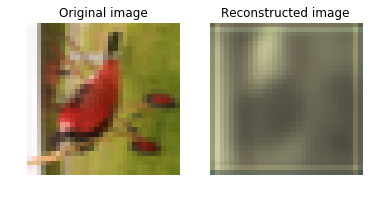

tensor([[[ 0.9843,  0.9686,  0.9686,  ...,  0.8980,  0.9569,  0.9843],
         [ 0.9765,  0.9647,  0.9647,  ...,  0.9137,  0.9765,  0.9882],
         [ 0.6549,  0.6549,  0.6549,  ...,  0.8510,  0.8510,  0.8627],
         ...,
         [ 0.5216,  0.4824,  0.4863,  ...,  0.4627,  0.4471,  0.4510],
         [ 0.4824,  0.4863,  0.4941,  ...,  0.4392,  0.4235,  0.4078],
         [ 0.4902,  0.5059,  0.4941,  ...,  0.4627,  0.4392,  0.4118]],

        [[ 0.9765,  0.9608,  0.9608,  ...,  0.7451,  0.9059,  0.9451],
         [ 0.9725,  0.9569,  0.9608,  ...,  0.7373,  0.9294,  0.9490],
         [ 0.6471,  0.6431,  0.6431,  ...,  0.7137,  0.8275,  0.8353],
         ...,
         [ 0.5098,  0.4980,  0.5098,  ...,  0.4902,  0.4784,  0.4902],
         [ 0.4902,  0.4980,  0.5059,  ...,  0.4784,  0.4667,  0.4667],
         [ 0.5020,  0.5176,  0.5098,  ...,  0.5020,  0.4784,  0.4745]],

        [[ 0.9804,  0.9686,  0.9686,  ...,  0.5725,  0.8784,  0.9451],
         [ 0.9725,  0.9569,  0.9569,  ...,  0

In [36]:
#plt.subplot(len(images), 2, 1)
#imshow_noax(original.detach().numpy().transpose(2,1,0), normalize=False)
#plt.title('Original image')
#plt.subplot(len(images), 3, 2)
#plt.title('Reconstructed')

i = 0
for original,reconstruction in images.items():
    if i == 1:
        plt.subplot(1, 2, 1)
        imshow_noax(original.detach().numpy().transpose(2,1,0), normalize=False)
        plt.title('Original image')
        plt.subplot(1, 2, 2)
        imshow_noax(reconstruction.detach().numpy().transpose(2,1,0), normalize=False)
        plt.title('Reconstructed image')
        plt.show()
        print(original)
        print(reconstruction)
        print(nn.MSELoss(original,reconstruction))
        break
    i += 1



#for original,reconstruction in images.items():
    #imshow_noax(original.detach().numpy().transpose(2,1,0), normalize=False)
    #print(reconstruction)
    #imshow_noax(reconstruction.detach().numpy().transpose(2,1,0), normalize=False)
    
#plt.show()

## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

Honestly, this part took me a while to figure out. I tried printing out graphs of the loss, which was helpful in the early stages. I initially copied the Three layer net and added batch normalization, which did pretty well but not superbly. I also added dropout on top of that, and experimented with [conv-relu-pool] architecture, which was okay but only got to like 55% in the first epoch. I messed around even more until I settled on the [batchnorm-relu-conv-pool] architecture. The main reason I bounced around so much is because I WASNT PATIENT ENOUGH early on in my training... I didn't really give stuff more than 1.5 epochs to train, and Adam was slower so I used SGD with nesterov momentum while I was designing the architecture. I settled on the large affine sections mostly by accident, when I realized that I could squeeze a bit more accuracy by adding an extra affine, and then another one, etc. I think the final network is super big, but again, I was impatient with my training in the earlier stages so here we are.  

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model). Think about how this compares to your validation set accuracy.

In [ ]:
#best_model = model 
check_accuracy_part34(loader_test, best_model)